# Locating Potential Venues for Homeless Shelters in the City of Toronto

The purpose of this notebook will be to locate potential venues for new homeless shelters in the city of Toronto and its adjacent neighbourhoods. This project will draw data from different sources, mainly the Toronto Open Data initiative. 

First, we will need information about Toronto's Neighbourhoods, we will scrape the data from the web and use a geojson to determine their corresponding latitude and longitude. 

Next, we define the criteria that will be used to select the best venues:
   1. **Accesibility:** Using Foursquare we will draw location data to determine the distance to train or bus stations
   2. **Socio-Economic:** Using low-income and high unemployment data, we will find "hot-zones" ideal for considering the new venue.

## Part 1: Setting up DataFrames

### 1.1 Import necessary libraries

In [1]:
import pandas as pd
import requests # library to handle requests
import numpy as np
import json
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import stats

%matplotlib inline 

#### First we scrape the data from different sources

### 1.2 Toronto Neighbourhoods and their location

#### Extract location information from geojson

In [2]:
!wget --quiet https://raw.githubusercontent.com/YaIzVaNa/Coursera_Capstone/master/Data/toronto_geojson.json -O toronto_geojson.json

In [3]:
toronto_geo2 = r'toronto_geojson.json' # geojson file

In [4]:
# Opening JSON file 
f = open('toronto_geojson.json',) 
  
# returns JSON object as a dictionary 
data = json.load(f) 
  
# Closing file 
f.close()

In [5]:
track=0
neighlat=[]
neighlong=[]
neighname=[]
for j in data['features']:
    
    count=0
    latcum=0
    longcum=0
    if('Multi' in j['geometry']['type']):
        for p in data['features'][40]['geometry']['coordinates']:
            for k in p:
                for r in k:
                    count+=1
                    latcum+=r[1]
                    longcum+=r[0]
    else:
        for i in j['geometry']['coordinates'][0]:
            count+=1
            latcum+=i[1]
            longcum+=i[0]        
    #print('{} Average position in {} is: {},{}'.format(track, j['properties']['HOOD'],latcum/count, longcum/count))
    neighlat.append(latcum/count)
    neighlong.append(longcum/count)
    neighname.append(j['properties']['HOOD'])
    track+=1


In [6]:
data={'Neighbourhood':neighname,'Latitude':neighlat,'Longitude':neighlong}
df_Neighloc=pd.DataFrame(data,columns=('Neighbourhood','Latitude','Longitude'))
df_Neighloc=df_Neighloc.sort_values('Neighbourhood')
df_Neighloc=df_Neighloc.reset_index(drop=True)

#### Some location info is  erronous, fix the data

In [7]:
df_Neighloc.set_value(55,'Latitude',43.742438) #Humbermede
df_Neighloc.set_value(55,'Longitude',-79.538981)

df_Neighloc.set_value(82,'Latitude',43.706333) #Mt Pleasant East
df_Neighloc.set_value(82,'Longitude',-79.382807)

df_Neighloc.set_value(121,'Latitude',43.734100) #Victoria village
df_Neighloc.set_value(121,'Longitude',-79.316574)

df_Neighloc.set_value(37,'Latitude',43.738388) #Eglinton East
df_Neighloc.set_value(37,'Longitude',-79.242133) 

df_Neighloc.set_value(76,'Latitude',43.821625) #Milliken
df_Neighloc.set_value(76,'Longitude',-79.283789)

df_Neighloc.set_value(1,'Latitude',43.787051) #Agincourt South-Malvern West
df_Neighloc.set_value(1,'Longitude',-79.255650) 

df_Neighloc.set_value(5,'Latitude',43.758634) #Bathurst Manor
df_Neighloc.set_value(5,'Longitude',-79.455460) 

df_Neighloc.set_value(138,'Latitude',43.764826) # York University Heights
df_Neighloc.set_value(138,'Longitude',-79.488494) 

df_Neighloc.set_value(24,'Latitude',43.719289) # Clairlea-Birchmount
df_Neighloc.set_value(24,'Longitude',-79.283050) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
 

Neighbourhood   Latitude  Longitude
0                      Agincourt North  43.804904 -79.262127
1         Agincourt South-Malvern West  43.787051 -79.255650
2                            Alderwood  43.600882 -79.545390
3                                Annex  43.673045 -79.399119
4                    Banbury-Don Mills  43.736493 -79.351286
5                       Bathurst Manor  43.758634 -79.455460
6                  Bay Street Corridor  43.657963 -79.387849
7                      Bayview Village  43.772742 -79.369285
8                Bayview Woods-Steeles  43.798730 -79.377331
9                 Bedford Park-Nortown  43.729506 -79.415947
10             Beechborough-Greenbrook  43.694088 -79.475109
11                             Bendale  43.750795 -79.247622
12               Birchcliffe-Cliffside  43.691695 -79.261559
13                         Black Creek  43.766883 -79.512350
14                         Blake-Jones  43.674680 -79.335981
15                Briar Hill-Belgravia  43.699686 -79.448991
16   Bridle Path-Sunnybrook-York Mills  43.733976 -79.368434
17                     Broadview North  43.689390 -79.357428
18                 Brookhaven-Amesbury  43.701186 -79.489515
19    Cabbagetown-South St. James Town  43.668780 -79.365733
20                  Caledonia-Fairbank  43.687261 -79.455523
21                           Casa Loma  43.682509 -79.406965
22              Centennial Scarborough  43.776369 -79.156917
23               Church-Yonge Corridor  43.655927 -79.376379
24                 Clairlea-Birchmount  43.719289 -79.283050
25                        Clanton Park  43.740524 -79.449480
26                          Cliffcrest  43.711090 -79.231440
27              Corso Italia-Davenport  43.677693 -79.444849
28                            Danforth  43.684570 -79.326172
29                  Danforth-East York  43.688161 -79.328648
..                                 ...        ...        ...
110                    South Riverdale  43.638232 -79.328776
111               St.Andrew-Windfields  43.757734 -79.368694
112                            Steeles  43.811096 -79.315560
113                Stonegate-Queensway  43.638662 -79.490301
114             Tam O'Shanter-Sullivan  43.784409 -79.302672
115                      Taylor-Massey  43.694760 -79.295083
116                        The Beaches  43.668416 -79.296986
117       Thistletown-Beaumond Heights  43.738105 -79.556966
118                   Thorncliffe Park  43.707678 -79.344498
119                  Trinity-Bellwoods  43.651345 -79.413390
120                         University  43.663405 -79.395553
121                   Victoria Village  43.734100 -79.316574
122  Waterfront Communities-The Island  43.629558 -79.414363
123                          West Hill  43.771586 -79.176159
124             West Humber-Clairville  43.720662 -79.599228
125                Westminster-Branson  43.775425 -79.456643
126                             Weston  43.701587 -79.519187
127                 Weston-Pelham Park  43.675190 -79.460634
128                   Wexford-Maryvale  43.752083 -79.298743
129                    Willowdale East  43.765636 -79.398912
130                    Willowdale West  43.769297 -79.424461
131   Willowridge-Martingrove-Richview  43.686777 -79.547651
132                             Woburn  43.770765 -79.221006
133                  Woodbine Corridor  43.674306 -79.312697
134                   Woodbine-Lumsden  43.693981 -79.309420
135                           Wychwood  43.678046 -79.427628
136                     Yonge-Eglinton  43.702983 -79.404455
137                     Yonge-St.Clair  43.690772 -79.399237
138            York University Heights  43.764826 -79.488494
139                 Yorkdale-Glen Park  43.712980 -79.449670

[140 rows x 3 columns]

### 1.3 Socio-economic data

In [8]:
df_demo = pd.read_csv('https://raw.githubusercontent.com/YaIzVaNa/Coursera_Capstone/master/Data/socio_demo_std.csv')


In [9]:
df_demo

Neighbourhood  Without after-tax income  \
0                      Agincourt North                    0.0546   
1         Agincourt South-Malvern West                    0.0542   
2                            Alderwood                    0.0327   
3                                Annex                    0.0236   
4                    Banbury-Don Mills                    0.0427   
5                       Bathurst Manor                    0.0441   
6                  Bay Street Corridor                    0.0436   
7                      Bayview Village                    0.0521   
8                Bayview Woods-Steeles                    0.0511   
9                 Bedford Park-Nortown                    0.0471   
10             Beechborough-Greenbrook                    0.0590   
11                             Bendale                    0.0579   
12               Birchcliffe-Cliffside                    0.0425   
13                         Black Creek                    0.0672   
14                         Blake-Jones                    0.0485   
15                Briar Hill-Belgravia                    0.0469   
16   Bridle Path-Sunnybrook-York Mills                    0.0574   
17                     Broadview North                    0.0339   
18                 Brookhaven-Amesbury                    0.0600   
19    Cabbagetown-South St. James Town                    0.0216   
20                  Caledonia-Fairbank                    0.0469   
21                           Casa Loma                    0.0276   
22              Centennial Scarborough                    0.0505   
23               Church-Yonge Corridor                    0.0242   
24                 Clairlea-Birchmount                    0.0584   
25                        Clanton Park                    0.0458   
26                          Cliffcrest                    0.0544   
27              Corso Italia-Davenport                    0.0415   
28                            Danforth                    0.0327   
29                  Danforth-East York                    0.0352   
..                                 ...                       ...   
110                    South Riverdale                    0.0320   
111               St.Andrew-Windfields                    0.0545   
112                            Steeles                    0.0495   
113                Stonegate-Queensway                    0.0353   
114             Tam O'Shanter-Sullivan                    0.0523   
115                      Taylor-Massey                    0.0626   
116                        The Beaches                    0.0389   
117       Thistletown-Beaumond Heights                    0.0542   
118                   Thorncliffe Park                    0.0889   
119                  Trinity-Bellwoods                    0.0221   
120                         University                    0.0251   
121                   Victoria Village                    0.0529   
122  Waterfront Communities-The Island                    0.0222   
123                          West Hill                    0.0598   
124             West Humber-Clairville                    0.0569   
125                Westminster-Branson                    0.0530   
126                             Weston                    0.0500   
127                 Weston-Pelham Park                    0.0483   
128                   Wexford-Maryvale                    0.0525   
129                    Willowdale East                    0.0635   
130                    Willowdale West                    0.0445   
131   Willowridge-Martingrove-Richview                    0.0454   
132                             Woburn                    0.0632   
133                  Woodbine Corridor                    0.0337   
134                   Woodbine-Lumsden                    0.0329   
135                           Wychwood                    0.0300   
136                     Yonge-Eglinton                    0.0410   
137          

### 1.4 Shelter location data

In [10]:
df_Shelters=pd.read_csv('https://raw.githubusercontent.com/YaIzVaNa/Coursera_Capstone/master/Data/shelters_wgs84.csv')

### 1.5 Check size of cleaned DataFrames

In [11]:
df_Neighloc.shape,df_demo.shape,df_Shelters.shape

((140, 3), (140, 25), (59, 20))

## Part 2: Display Location Data with Folium

### 2.1 Import the required libraries

In [12]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [13]:
import folium

### 2.2 Display Toronto Neighborhoods and Shelters in a map

In [14]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[43.7181557,-79.5181422], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_Neighloc['Latitude'], df_Neighloc['Longitude'], df_Neighloc['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
for lat, lng, borough, neighborhood in zip(df_Shelters['Y'], df_Shelters['X'], df_Shelters['NAME'], df_Shelters['NEIGHBOU_1']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#33ba32',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Part 3: Analyze socio-demographic data:

We begin by exploring the dataframe containing economic indicators, such as unemployment rate, individual income data.

In [15]:
df_demoCpy=df_demo
df_demoCpy

Neighbourhood  Without after-tax income  \
0                      Agincourt North                    0.0546   
1         Agincourt South-Malvern West                    0.0542   
2                            Alderwood                    0.0327   
3                                Annex                    0.0236   
4                    Banbury-Don Mills                    0.0427   
5                       Bathurst Manor                    0.0441   
6                  Bay Street Corridor                    0.0436   
7                      Bayview Village                    0.0521   
8                Bayview Woods-Steeles                    0.0511   
9                 Bedford Park-Nortown                    0.0471   
10             Beechborough-Greenbrook                    0.0590   
11                             Bendale                    0.0579   
12               Birchcliffe-Cliffside                    0.0425   
13                         Black Creek                    0.0672   
14                         Blake-Jones                    0.0485   
15                Briar Hill-Belgravia                    0.0469   
16   Bridle Path-Sunnybrook-York Mills                    0.0574   
17                     Broadview North                    0.0339   
18                 Brookhaven-Amesbury                    0.0600   
19    Cabbagetown-South St. James Town                    0.0216   
20                  Caledonia-Fairbank                    0.0469   
21                           Casa Loma                    0.0276   
22              Centennial Scarborough                    0.0505   
23               Church-Yonge Corridor                    0.0242   
24                 Clairlea-Birchmount                    0.0584   
25                        Clanton Park                    0.0458   
26                          Cliffcrest                    0.0544   
27              Corso Italia-Davenport                    0.0415   
28                            Danforth                    0.0327   
29                  Danforth-East York                    0.0352   
..                                 ...                       ...   
110                    South Riverdale                    0.0320   
111               St.Andrew-Windfields                    0.0545   
112                            Steeles                    0.0495   
113                Stonegate-Queensway                    0.0353   
114             Tam O'Shanter-Sullivan                    0.0523   
115                      Taylor-Massey                    0.0626   
116                        The Beaches                    0.0389   
117       Thistletown-Beaumond Heights                    0.0542   
118                   Thorncliffe Park                    0.0889   
119                  Trinity-Bellwoods                    0.0221   
120                         University                    0.0251   
121                   Victoria Village                    0.0529   
122  Waterfront Communities-The Island                    0.0222   
123                          West Hill                    0.0598   
124             West Humber-Clairville                    0.0569   
125                Westminster-Branson                    0.0530   
126                             Weston                    0.0500   
127                 Weston-Pelham Park                    0.0483   
128                   Wexford-Maryvale                    0.0525   
129                    Willowdale East                    0.0635   
130                    Willowdale West                    0.0445   
131   Willowridge-Martingrove-Richview                    0.0454   
132                             Woburn                    0.0632   
133                  Woodbine Corridor                    0.0337   
134                   Woodbine-Lumsden                    0.0329   
135                           Wychwood                    0.0300   
136                     Yonge-Eglinton                    0.0410   
137          

### 3.1 Before analyzing the socio-demographic dataframe, check the data type

In [16]:
df_demoCpy.dtypes

Neighbourhood                                                                          object
Without after-tax income                                                              float64
With after-tax income                                                                 float64
Under 10,000                                                                          float64
10,000 to 19,999                                                                      float64
20,000 to 29,999                                                                      float64
30,000 to 39,999                                                                      float64
40,000 to 49,999                                                                      float64
50,000 to 59,999                                                                      float64
60,000 to 69,999                                                                      float64
70,000 to 79,999                                            

### 3.2 Data was wrangled a priori, from the source, so every category is in order

In [17]:
df_demoCpy=df_demoCpy.drop('Neighbourhood',1)

This commented out code was used to change the data type into a number, used in previous versions of the notebook, however I opted for directly modifying the data from the source.

In [18]:
#df_demoCpy=df_demoCpy.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))

In [19]:
#df_demoCpy=df_demoCpy.apply(pd.to_numeric, errors='raise')
#df_demoCpy.dtypes

### 3.3 Now we perform some exploratory procedures on the data

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002213753F908>,
      dtype=object)

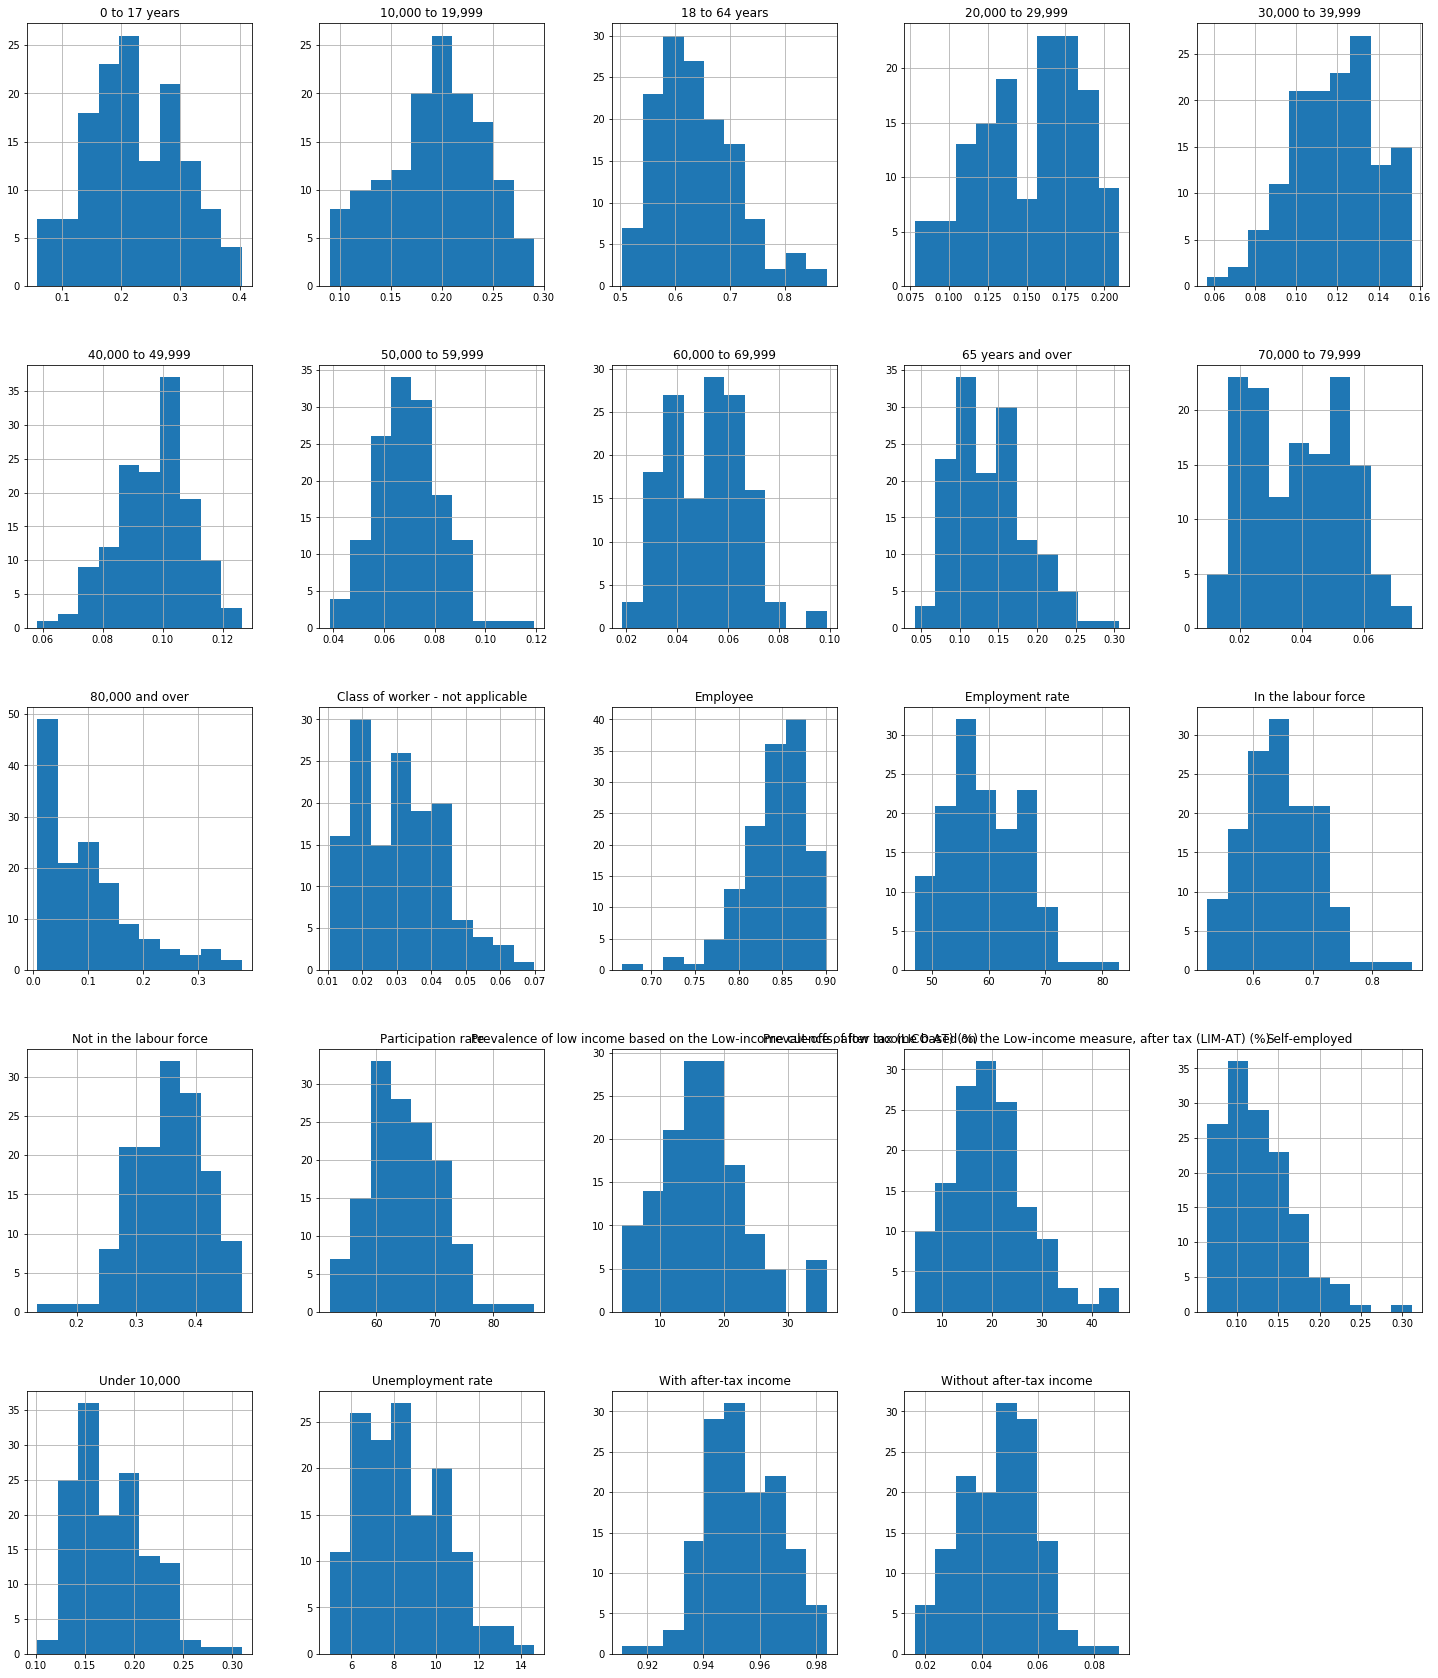

In [20]:
fig = plt.figure(figsize = (25,30))
ax = fig.gca()
df_demoCpy.hist(ax = ax)

### 3.4 We can become familiarized with outlier neighbourhoods

#### Check neighbourhoods with high unemployment

In [88]:
df_demo[df_demoCpy['Unemployment rate'] > df_demoCpy['Unemployment rate'].quantile(0.95)]

Neighbourhood  Without after-tax income  \
13                         Black Creek                    0.0672   
45              Glenfield-Jane Heights                    0.0622   
81   Mount Olive-Silverstone-Jamestown                    0.0734   
90                            Oakridge                    0.0679   
108                Scarborough Village                    0.0665   
118                   Thorncliffe Park                    0.0889   
123                          West Hill                    0.0598   

     With after-tax income  Under 10,000  10,000 to 19,999  20,000 to 29,999  \
13                  0.9328        0.2197            0.2784            0.1937   
45                  0.9378        0.1948            0.2622            0.2090   
81                  0.9266        0.2309            0.2541            0.1953   
90                  0.9321        0.2320            0.2894            0.1826   
108                 0.9335        0.2179            0.2494            0.1732   
118                 0.9111        0.2328            0.2717            0.1850   
123                 0.9402        0.1981            0.2343            0.1701   

     30,000 to 39,999  40,000 to 49,999  50,000 to 59,999  60,000 to 69,999  \
13             0.1501            0.0847            0.0386            0.0183   
45             0.1491            0.0934            0.0467            0.0234   
81             0.1437            0.0880            0.0438            0.0220   
90             0.1163            0.0724            0.0454            0.0304   
108            0.1237            0.0946            0.0541            0.0340   
118            0.1058            0.0774            0.0464            0.0331   
123            0.1335            0.1050            0.0646            0.0375   

     ...  65 years and over  \
13   ...             0.1049   
45   ...             0.1151   
81   ...             0.0754   
90   ...             0.0828   
108  ...             0.0750   
118  ...             0.0701   
123  ...             0.1077   

     Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)  \
13                                                25.9                                    
45                                                20.9                                    
81                                                21.8                                    
90                                                35.0                                    
108                                               25.7                                    
118                                               36.0                                    
123                                               20.8                                    

     Not in the labour force  In the labour force  Participation rate  \
13                    0.4515               0.5485                54.8   
45                    0.4497               0.5503                55.0   
81                    0.4264               0.5736                57.0   
90                    0.4282               0.5718                57.0   
108                   0.4233               0.5767                58.0   
118                   0.4433               0.5567                56.0   
123                   0.4152               0.5848                59.0   

     Employment rate  Unemployment rate  Class of worker - not applicable  \
13              47.8               12.7                            0.0597   
45              49.0               12.0                            0.0520   
81              50.0               12.0                            0.0555   
90              49.0               14.6                            0.0698   
108             50.0               13.0                            0.0610   
118             49.0               13.0                            0.0625   
123             52.0               12.0                            0.0531   

     Employee  Self-employ

In [89]:
df_demoCpy.insert(loc=0,column='Neighbourhood', value=df_demo['Neighbourhood'])

ValueError: cannot insert Neighbourhood, already exists

Display info on a map, to get familiarized with the overall characteristics of the neighbourhoods

In [27]:
Toronto_map = folium.Map(location=[43.7181557,-79.5181422], zoom_start=10, tiles='Open street map')

Toronto_map.choropleth(
    geo_data=toronto_geo2,
    data=df_demoCpy,
    columns=['Neighbourhood', 'Unemployment rate'],
    key_on='feature.properties.HOOD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Unemployment rate'
)
    
for lat, lng, borough, neighborhood in zip(df_Shelters['Y'], df_Shelters['X'], df_Shelters['NAME'], df_Shelters['NEIGHBOU_1']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#33ba32',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
# display map
Toronto_map

#### Check neighbourhoods with low income

In [28]:
df_demo[df_demoCpy['Under 10,000'] > df_demoCpy['Under 10,000'].quantile(0.95)]

Neighbourhood  Without after-tax income  \
1    Agincourt South-Malvern West                    0.0542   
6             Bay Street Corridor                    0.0436   
48                     Henry Farm                    0.0666   
62           Kensington-Chinatown                    0.0266   
85               Newtonbrook East                    0.0527   
129               Willowdale East                    0.0635   
130               Willowdale West                    0.0445   

     With after-tax income  Under 10,000  10,000 to 19,999  20,000 to 29,999  \
1                   0.9458        0.2379            0.2405            0.1594   
6                   0.9564        0.3095            0.1307            0.0952   
48                  0.9334        0.2599            0.1865            0.1395   
62                  0.9734        0.2373            0.2611            0.1422   
85                  0.9473        0.2560            0.2101            0.1291   
129                 0.9365        0.2694            0.1647            0.1079   
130                 0.9555        0.2424            0.1839            0.1163   

     30,000 to 39,999  40,000 to 49,999  50,000 to 59,999  60,000 to 69,999  \
1              0.1176            0.0863            0.0596            0.0360   
6              0.0858            0.0755            0.0683            0.0674   
48             0.1127            0.0945            0.0693            0.0531   
62             0.0989            0.0773            0.0518            0.0385   
85             0.0954            0.0788            0.0629            0.0500   
129            0.0925            0.0864            0.0722            0.0578   
130            0.0974            0.0813            0.0662            0.0578   

     ...  65 years and over  \
1    ...             0.1288   
6    ...             0.0419   
48   ...             0.0657   
62   ...             0.1966   
85   ...             0.1620   
129  ...             0.0897   
130  ...             0.2170   

     Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)  \
1                                                 18.7                                    
6                                                 36.1                                    
48                                                25.4                                    
62                                                34.9                                    
85                                                24.9                                    
129                                               26.7                                    
130                                               23.6                                    

     Not in the labour force  In the labour force  Participation rate  \
1                     0.4093               0.5907                59.0   
6                     0.3737               0.6263                62.7   
48                    0.3484               0.6516                65.0   
62                    0.3743               0.6257                63.0   
85                    0.4208               0.5792                58.0   
129                   0.3895               0.6105                61.0   
130                   0.4206               0.5794                58.0   

     Employment rate  Unemployment rate  Class of worker - not applicable  \
1               53.2                9.8                            0.0390   
6               56.2               10.2                            0.0430   
48              59.0               10.3                            0.0371   
62              58.0                8.2                            0.0292   
85              53.0                8.8                            0.0353   
129             56.0                9.0                            0.0399   
130             52.0                9.8                            0.0418   

     Employee  Self-employed  
1      0.8461         0.1149  

In [29]:
Toronto_map = folium.Map(location=[43.7181557,-79.5181422], zoom_start=10, tiles='Open street map')

Toronto_map.choropleth(
    geo_data=toronto_geo2,
    data=df_demoCpy,
    columns=['Neighbourhood', 'Under 10,000'],
    key_on='feature.properties.HOOD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='People under 10,000'
)
    
for lat, lng, borough, neighborhood in zip(df_Shelters['Y'], df_Shelters['X'], df_Shelters['NAME'], df_Shelters['NEIGHBOU_1']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#33ba32',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
# display map
Toronto_map

Note that a neighbourhood in the heart of downtown toronto has the greatest percentage of people making less than 10,000 a year...

#### Now we check areas with high income

In [30]:
Toronto_map = folium.Map(location=[43.7181557,-79.5181422], zoom_start=10, tiles='Open street map')

Toronto_map.choropleth(
    geo_data=toronto_geo2,
    data=df_demoCpy,
    columns=['Neighbourhood', '80,000 and over'],
    key_on='feature.properties.HOOD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='People over 80,000'
)
    
for lat, lng, borough, neighborhood in zip(df_Shelters['Y'], df_Shelters['X'], df_Shelters['NAME'], df_Shelters['NEIGHBOU_1']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#33ba32',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
# display map
Toronto_map

#### Lastly, we map neighbourhoods with a low-income indicator

In [31]:
Toronto_map = folium.Map(location=[43.7181557,-79.5181422], zoom_start=10, tiles='Open street map')

Toronto_map.choropleth(
    geo_data=toronto_geo2,
    data=df_demoCpy,
    columns=['Neighbourhood', 'Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)'],
    key_on='feature.properties.HOOD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)'
)
    
for lat, lng, borough, neighborhood in zip(df_Shelters['Y'], df_Shelters['X'], df_Shelters['NAME'], df_Shelters['NEIGHBOU_1']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#33ba32',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
# display map
Toronto_map

We start to see a trend, although somewhat paradoxically, the high income areas are also the ones most profoundly affected by income inequality. We can see most shelters are situated on neighbourhoods with high low-income cut-off indicator. 

Next we will run a k-means method, comparing the resulting clusters to determine if there is a trend between them. clusters.

### To run the clustering algorithm we drop the Neighbourhood column temporarily, since it is of type string

In [32]:
df_demo_km=df_demoCpy.drop('Neighbourhood',1)

### Now let's standarize the data

In [33]:
from sklearn.preprocessing import StandardScaler

X = df_demo_km.values
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.63460653, -0.63460653,  1.20941564, ...,  0.64169044,
         0.65270062, -0.74275046],
       [ 0.60414367, -0.60414367,  1.67255778, ...,  0.64987676,
         0.11783613, -0.28543346],
       [-1.03323473,  1.03323473, -1.0021566 , ..., -0.98738698,
         0.63649261, -0.26686221],
       ...,
       [-1.71864895,  1.71864895, -1.64617082, ..., -1.32302605,
        -0.8492421 ,  1.10508878],
       [ 0.53560225, -0.53560225,  1.47524279, ...,  1.2392917 ,
         1.05790099, -1.26274542],
       [ 0.26143656, -0.26143656, -0.36636383, ..., -0.22605934,
         0.83909279, -0.65917984]])

### With a clean and standarized dataframe, now we can run a k-means clustering algorithm

In [71]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 0 1 1 1 1 0 1 0 2 0 0 1 0 1 0 2 1 0 1 0 2 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1
 0 0 0 1 0 0 1 2 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 2 1 0 1 2 2 2 1 1 0
 0 1 0 1 0 1 0 0 2 1 1 0 0 1 2 0 0 1 0 1 1 0 1 1 0 2 0 0 0 1 2 0 1 0 0 1 1
 2 0 1 0 0 2 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]


### Restore the Neighbourhood column and add cluster labels

In [72]:
try:
    df_demo_km.insert(loc=0,column='Neighbourhood', value=df_demo['Neighbourhood'])
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
    print("Column already inserted.")

try:
    df_demo_km['Labels']=labels
except:
    df_demo_km=df_demoCpy.drop('Labels',1)
    df_demo_km['Labels']=labels

Column already inserted.


In [73]:
df_demo_km.groupby('Labels').mean()

Without after-tax income  With after-tax income  Under 10,000  \
Labels                                                                  
0                       0.056230               0.943770      0.204726   
1                       0.035307               0.964693      0.151075   
2                       0.041786               0.958214      0.144586   

        10,000 to 19,999  20,000 to 29,999  30,000 to 39,999  \
Labels                                                         
0               0.226358          0.172896          0.129680   
1               0.173202          0.139472          0.114375   
2               0.113600          0.098400          0.084571   

        40,000 to 49,999  50,000 to 59,999  60,000 to 69,999  \
Labels                                                         
0               0.096419          0.061338          0.039787   
1               0.101567          0.080614          0.062521   
2               0.080229          0.071686          0.061071   

        70,000 to 79,999  ...  65 years and over  \
Labels                    ...                      
0               0.026590  ...           0.124148   
1               0.049760  ...           0.152307   
2               0.054679  ...           0.146000   

        Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)  \
Labels                                                                                       
0                                               20.273913                                    
1                                               14.892982                                    
2                                                8.428571                                    

        Not in the labour force  In the labour force  Participation rate  \
Labels                                                                     
0                      0.398188             0.601812           60.242029   
1                      0.306254             0.693746           69.382456   
2                      0.335507             0.664493           66.507143   

        Employment rate  Unemployment rate  Class of worker - not applicable  \
Labels                                                                         
0             54.360870           9.862319                          0.040800   
1             64.698246           6.940351                          0.022447   
2             62.207143           6.585714                          0.018136   

        Employee  Self-employed  
Labels                           
0       0.859301       0.099894  
1       0.838614       0.138933  
2       0.767893       0.213964  

[3 rows x 24 columns]

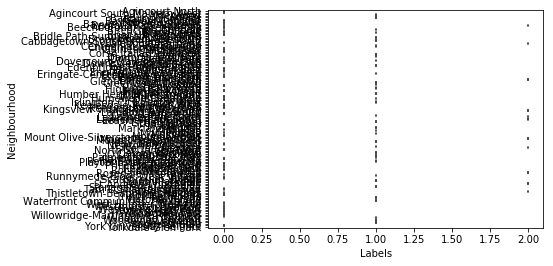

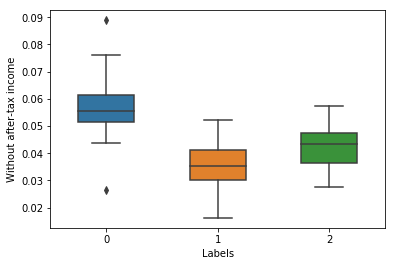

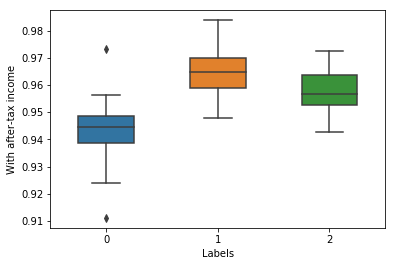

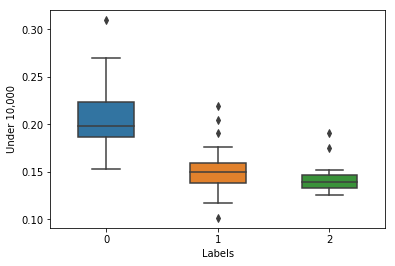

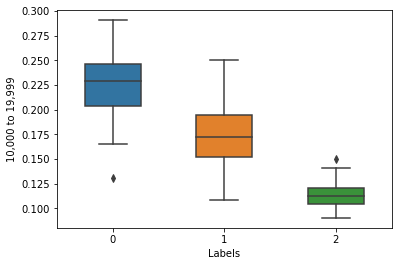

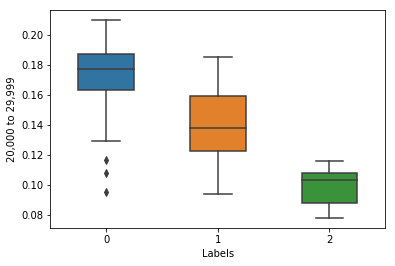

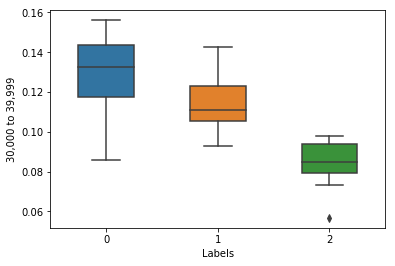

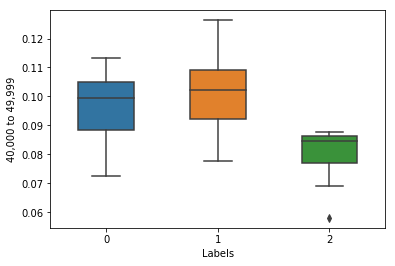

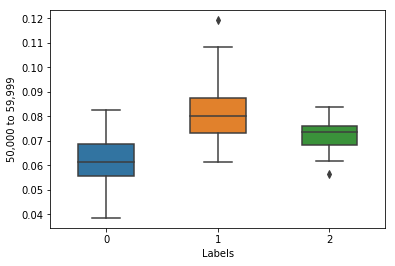

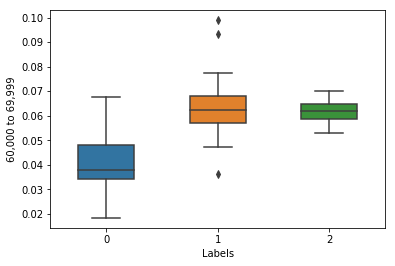

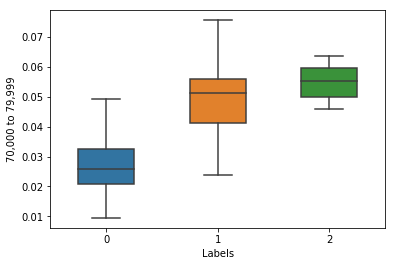

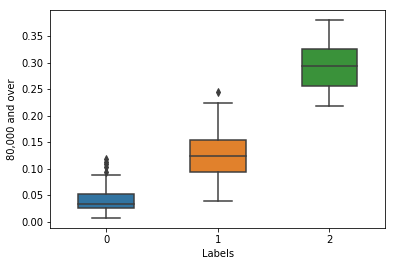

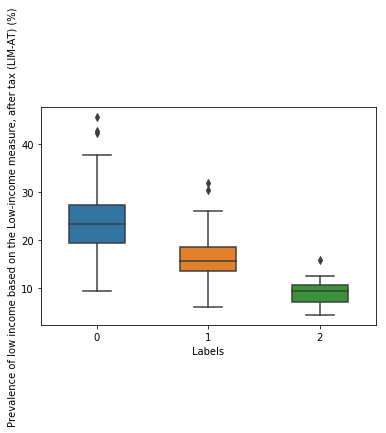

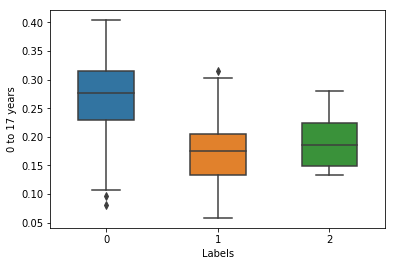

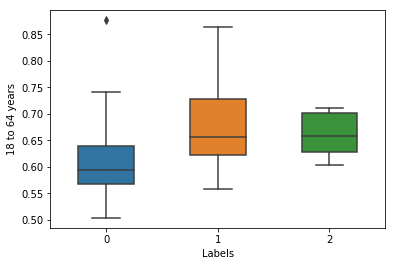

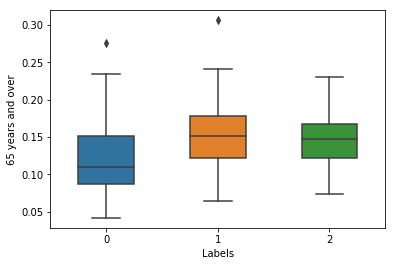

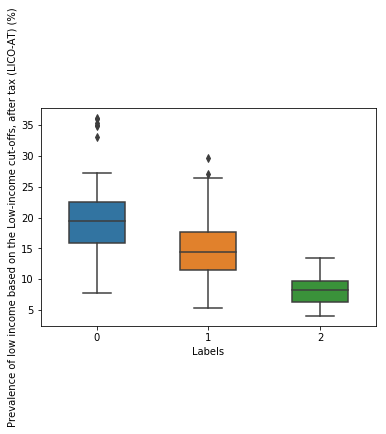

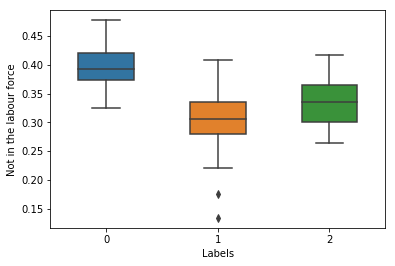

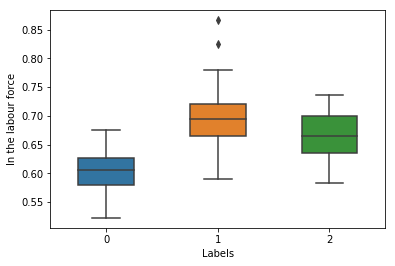

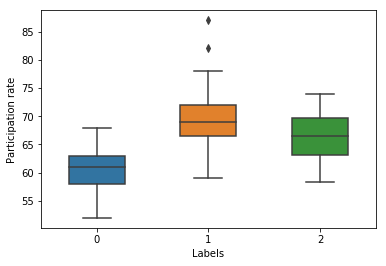

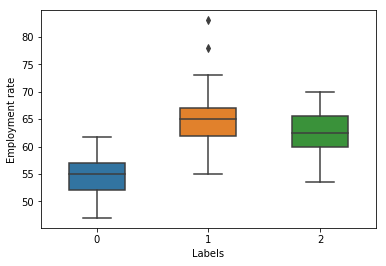

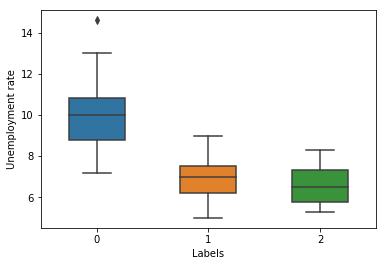

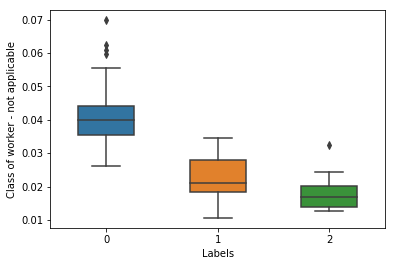

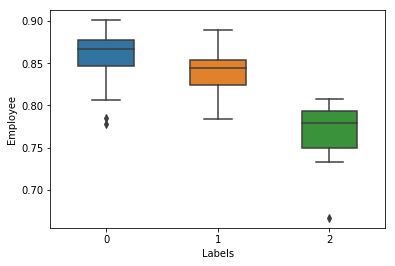

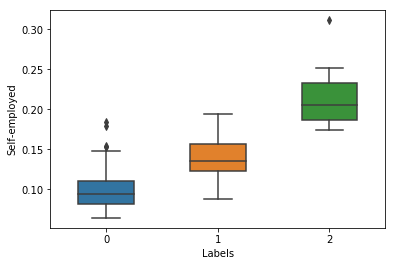

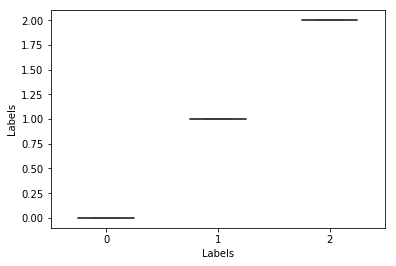

In [74]:
import seaborn as sns

for i in df_demo_km.columns:
    sns.boxplot(y=i, x='Labels',data=df_demo_km,width=0.5)
    plt.show()


In [90]:
Toronto_map = folium.Map(location=[43.7181557,-79.5181422], zoom_start=10, tiles='Open street map')
Toronto_map.choropleth(
    geo_data=toronto_geo2,
    data=df_demo_km,
    columns=['Neighbourhood', 'Labels'],
    key_on='feature.properties.HOOD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Labels'
)
  
    
for lat, lng, borough, neighborhood in zip(df_Shelters['Y'], df_Shelters['X'], df_Shelters['NAME'], df_Shelters['NEIGHBOU_1']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#33ba32',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
# display map
Toronto_map

### We briefly describe the differences between the three neighbourhoods

### Cluster 1:

This cluster includes neighbourhoods with common suburb venues, such as restaurants, coffee or pizza places

In [77]:
df_demo_km.loc[df_demo_km['Labels'] == 0].describe()

Without after-tax income  With after-tax income  Under 10,000  \
count                  69.00000               69.00000     69.000000   
mean                    0.05623                0.94377      0.204726   
std                     0.00855                0.00855      0.028697   
min                     0.02660                0.91110      0.153200   
25%                     0.05130                0.93870      0.186600   
50%                     0.05550                0.94450      0.198100   
75%                     0.06130                0.94870      0.223300   
max                     0.08890                0.97340      0.309500   

       10,000 to 19,999  20,000 to 29,999  30,000 to 39,999  40,000 to 49,999  \
count         69.000000         69.000000         69.000000         69.000000   
mean           0.226358          0.172896          0.129680          0.096419   
std            0.030173          0.023493          0.017298          0.011049   
min            0.130700          0.095200          0.085800          0.072400   
25%            0.203900          0.162800          0.117600          0.088300   
50%            0.228900          0.177100          0.132500          0.099500   
75%            0.246100          0.187100          0.143500          0.105000   
max            0.290700          0.209600          0.156100          0.113300   

       50,000 to 59,999  60,000 to 69,999  70,000 to 79,999  ...  \
count         69.000000         69.000000         69.000000  ...   
mean           0.061338          0.039787          0.026590  ...   
std            0.009542          0.009464          0.009127  ...   
min            0.038600          0.018300          0.009500  ...   
25%            0.055500          0.034000          0.020800  ...   
50%            0.061300          0.037900          0.025800  ...   
75%            0.068700          0.048000          0.032400  ...   
max            0.082400          0.067400          0.049100  ...   

       Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)  \
count                                          69.000000                                    
mean                                           20.273913                                    
std                                             6.180107                                    
min                                             7.800000                                    
25%                                            15.900000                                    
50%                                            19.400000                                    
75%                                            22.500000                                    
max                                            36.100000                                    

       Not in the labour force  In the labour force  Participation rate  \
count                69.000000            69.000000           69.000000   
mean                  0.398188             0.601812           60.242029   
std                   0.034810             0.034810            3.499891   
min                   0.324200             0.522500           52.000000   
25%                   0.373500             0.579200           58.000000   
50%                   0.393300             0.606700           61.000000   
75%                   0.420800             0.626500           63.000000   
max                   0.477500             0.675800           68.000000   

       Employment rate  Unemployment rate  Class of worker - not applicable  \
count        69.000000          69.000000                         69.000000   
mean         54.360870           9.862319                          0.040800   
std           3.474623           1.427369                          0.008953   
min          47.000000           7.200000                          0.026100   
25%          52.000000           8.800000                          0.035300   
50%          55.000000     

### Cluster 2:

Can be considered to be mainly neighbourhoods where train stations, storage and warehouses are prevalent

In [78]:
df_demo_km.loc[df_demo_km['Labels'] == 1].describe()

Without after-tax income  With after-tax income  Under 10,000  \
count                 57.000000              57.000000     57.000000   
mean                   0.035307               0.964693      0.151075   
std                    0.008510               0.008510      0.018937   
min                    0.016200               0.947900      0.101600   
25%                    0.030100               0.959000      0.138200   
50%                    0.035400               0.964600      0.149900   
75%                    0.041000               0.969900      0.158900   
max                    0.052100               0.983800      0.219000   

       10,000 to 19,999  20,000 to 29,999  30,000 to 39,999  40,000 to 49,999  \
count         57.000000         57.000000         57.000000         57.000000   
mean           0.173202          0.139472          0.114375          0.101567   
std            0.031173          0.021988          0.012840          0.011082   
min            0.108600          0.094000          0.092800          0.077800   
25%            0.151700          0.122800          0.105400          0.092300   
50%            0.172100          0.138100          0.110900          0.102200   
75%            0.194600          0.159000          0.122800          0.109200   
max            0.250600          0.184800          0.142600          0.126300   

       50,000 to 59,999  60,000 to 69,999  70,000 to 79,999  ...  \
count         57.000000         57.000000         57.000000  ...   
mean           0.080614          0.062521          0.049760  ...   
std            0.010732          0.010678          0.010311  ...   
min            0.061600          0.036100          0.023900  ...   
25%            0.073200          0.056900          0.041200  ...   
50%            0.080200          0.062500          0.051100  ...   
75%            0.087500          0.068100          0.055900  ...   
max            0.119200          0.098900          0.075500  ...   

       Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)  \
count                                          57.000000                                    
mean                                           14.892982                                    
std                                             5.252240                                    
min                                             5.300000                                    
25%                                            11.500000                                    
50%                                            14.500000                                    
75%                                            17.600000                                    
max                                            29.700000                                    

       Not in the labour force  In the labour force  Participation rate  \
count                57.000000            57.000000           57.000000   
mean                  0.306254             0.693746           69.382456   
std                   0.050438             0.050438            5.022454   
min                   0.133700             0.591000           59.000000   
25%                   0.279400             0.664900           66.500000   
50%                   0.305700             0.694300           69.000000   
75%                   0.335100             0.720600           72.000000   
max                   0.409000             0.866300           87.000000   

       Employment rate  Unemployment rate  Class of worker - not applicable  \
count        57.000000          57.000000                         57.000000   
mean         64.698246           6.940351                          0.022447   
std           5.034222           1.000153                          0.005895   
min          55.000000           5.000000                          0.010600   
25%          62.000000           6.200000                          0.018400   
50%          65.000000     

### Cluster 3:

This cluster is tricky to classify, as it is only one neighbourhood. We see that differing from the others, this cluster has a mixture of playgrounds, warehouses and stores.

In [79]:
df_demo_km.loc[df_demo_km['Labels'] == 2].describe()

Without after-tax income  With after-tax income  Under 10,000  \
count                 14.000000              14.000000     14.000000   
mean                   0.041786               0.958214      0.144586   
std                    0.009343               0.009343      0.018131   
min                    0.027500               0.942600      0.125500   
25%                    0.036400               0.952675      0.133450   
50%                    0.043450               0.956550      0.139350   
75%                    0.047325               0.963600      0.146825   
max                    0.057400               0.972500      0.190600   

       10,000 to 19,999  20,000 to 29,999  30,000 to 39,999  40,000 to 49,999  \
count         14.000000         14.000000         14.000000         14.000000   
mean           0.113600          0.098400          0.084571          0.080229   
std            0.017020          0.012692          0.011208          0.008799   
min            0.090200          0.077900          0.056700          0.058100   
25%            0.104750          0.087825          0.079475          0.077125   
50%            0.112250          0.102850          0.085050          0.084500   
75%            0.120325          0.107700          0.094000          0.086300   
max            0.150200          0.116000          0.097700          0.087600   

       50,000 to 59,999  60,000 to 69,999  70,000 to 79,999  ...  \
count         14.000000         14.000000         14.000000  ...   
mean           0.071686          0.061071          0.054679  ...   
std            0.007337          0.005104          0.006174  ...   
min            0.056700          0.052900          0.045800  ...   
25%            0.068475          0.058675          0.049725  ...   
50%            0.073550          0.061750          0.055050  ...   
75%            0.075875          0.064600          0.059550  ...   
max            0.083700          0.070200          0.063400  ...   

       Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)  \
count                                          14.000000                                    
mean                                            8.428571                                    
std                                             2.520204                                    
min                                             4.100000                                    
25%                                             6.275000                                    
50%                                             8.350000                                    
75%                                             9.775000                                    
max                                            13.400000                                    

       Not in the labour force  In the labour force  Participation rate  \
count                14.000000            14.000000           14.000000   
mean                  0.335507             0.664493           66.507143   
std                   0.043696             0.043696            4.416135   
min                   0.264500             0.583000           58.300000   
25%                   0.300650             0.634850           63.200000   
50%                   0.335050             0.664950           66.500000   
75%                   0.365150             0.699350           69.750000   
max                   0.417000             0.735500           74.000000   

       Employment rate  Unemployment rate  Class of worker - not applicable  \
count        14.000000          14.000000                         14.000000   
mean         62.207143           6.585714                          0.018136   
std           4.505119           0.965447                          0.005421   
min          53.600000           5.300000                          0.012700   
25%          60.000000           5.775000                          0.013975   
50%          62.500000     

## Part 4:  Get train stations and public transport routes

### Define Foursquare ID & Credentials

In [80]:
CLIENT_ID = '3B12YESKZWGLATGW0PZ10F5GLGQSCNLCV1ADBAH05ZSMMXEI' # your Foursquare ID
CLIENT_SECRET = 'DBV040MHE1HLQJSMD0H4JKROPLB1FFBXQXJ00FKMDOBVM40M' # your Foursquare Secret
VERSION = '20180606'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3B12YESKZWGLATGW0PZ10F5GLGQSCNLCV1ADBAH05ZSMMXEI
CLIENT_SECRET:DBV040MHE1HLQJSMD0H4JKROPLB1FFBXQXJ00FKMDOBVM40M


### Create the URL to query to FourSquare

In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius, query, LIMIT): # After radius include query with search string
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            query,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Obtain neraby public stations close to each Neighbourhood

In [83]:
train_venues = getNearbyVenues(names=df_Neighloc['Neighbourhood'],
                                   latitudes=df_Neighloc['Latitude'],
                                   longitudes=df_Neighloc['Longitude'],
                                   radius=450,
                                   query='station',
                                   LIMIT=300
                                  )

Agincourt North
Agincourt South-Malvern West
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park-Nortown
Beechborough-Greenbrook
Bendale
Birchcliffe-Cliffside
Black Creek
Blake-Jones
Briar Hill-Belgravia
Bridle Path-Sunnybrook-York Mills
Broadview North
Brookhaven-Amesbury
Cabbagetown-South St. James Town
Caledonia-Fairbank
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth-East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson
Downsview-Roding-CFB
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Eringate-Centennial-West Deane
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Humber Summ

### Display neighbourhood categories, along with labels

In [84]:
train_venues

Neighbourhood  Neighborhood Latitude  \
0        Agincourt South-Malvern West              43.787051   
1        Agincourt South-Malvern West              43.787051   
2        Agincourt South-Malvern West              43.787051   
3                           Alderwood              43.600882   
4                 Bay Street Corridor              43.657963   
5                 Bay Street Corridor              43.657963   
6                 Bay Street Corridor              43.657963   
7                 Bay Street Corridor              43.657963   
8                 Bay Street Corridor              43.657963   
9                 Bay Street Corridor              43.657963   
10                Bay Street Corridor              43.657963   
11                Bay Street Corridor              43.657963   
12                Bay Street Corridor              43.657963   
13                Bay Street Corridor              43.657963   
14                    Bayview Village              43.772742   
15                    Bayview Village              43.772742   
16                    Bayview Village              43.772742   
17            Beechborough-Greenbrook              43.694088   
18              Birchcliffe-Cliffside              43.691695   
19               Briar Hill-Belgravia              43.699686   
20               Briar Hill-Belgravia              43.699686   
21                    Broadview North              43.689390   
22                          Casa Loma              43.682509   
23                          Casa Loma              43.682509   
24                          Casa Loma              43.682509   
25              Church-Yonge Corridor              43.655927   
26              Church-Yonge Corridor              43.655927   
27              Church-Yonge Corridor              43.655927   
28              Church-Yonge Corridor              43.655927   
29                Clairlea-Birchmount              43.719289   
..                                ...                    ...   
123                    South Parkdale              43.636164   
124                    South Parkdale              43.636164   
125                    South Parkdale              43.636164   
126               Stonegate-Queensway              43.638662   
127                     Taylor-Massey              43.694760   
128                       The Beaches              43.668416   
129                       The Beaches              43.668416   
130                  Thorncliffe Park              43.707678   
131                        University              43.663405   
132                        University              43.663405   
133            West Humber-Clairville              43.720662   
134            West Humber-Clairville              43.720662   
135            West Humber-Clairville              43.720662   
136            West Humber-Clairville              43.720662   
137                Weston-Pelham Park              43.675190   
138                Weston-Pelham Park              43.675190   
139                  Wexford-Maryvale              43.752083   
140                   Willowdale West              43.769297   
141  Willowridge-Martingrove-Richview              43.686777   
142  Willowridge-Martingrove-Richview              43.686777   
143                          Wychwood              43.678046   
144                          Wychwood              43.678046   
145                    Yonge-Eglinton              43.702983   
146                    Yonge-Eglinton              43.702983   
147                    Yonge-St.Clair              43.690772   
148                    Yonge-St.Clair              43.690772   
149                    Yonge-St.Clair              43.690772   
150           York University Heights              43.764826   
151           York University Heights              43.764826   
152           York University Heights              43.764826   

     Neighborhood Longitude  \
0                -79.255

### Visualize the numbers of venues obtained for each neighbourhood

In [85]:
train_venues.groupby('Neighbourhood').count()

Neighborhood Latitude  \
Neighbourhood                                              
Agincourt South-Malvern West                           3   
Alderwood                                              1   
Bay Street Corridor                                   10   
Bayview Village                                        3   
Beechborough-Greenbrook                                1   
Birchcliffe-Cliffside                                  1   
Briar Hill-Belgravia                                   2   
Broadview North                                        1   
Casa Loma                                              3   
Church-Yonge Corridor                                  4   
Clairlea-Birchmount                                    1   
Clanton Park                                           1   
Corso Italia-Davenport                                 2   
Danforth                                               3   
Don Valley Village                                     1   
Dorset Park                                            2   
Dovercourt-Wallace Emerson                             2   
Dufferin Grove                                         3   
East End-Danforth                                      2   
Eglinton East                                          1   
Etobicoke West Mall                                    1   
Flemingdon Park                                        1   
Forest Hill South                                      1   
Greenwood-Coxwell                                      3   
High Park North                                        2   
High Park-Swansea                                      1   
Highland Creek                                         1   
Humbermede                                             1   
Humewood-Cedarvale                                     1   
Islington-City Centre West                             5   
...                                                  ...   
Moss Park                                              7   
Mount Olive-Silverstone-Jamestown                      1   
Mount Pleasant East                                    1   
Mount Pleasant West                                    2   
North Riverdale                                        3   
North St. James Town                                   5   
Oakwood Village                                        1   
Old East York                                          1   
Palmerston-Little Italy                                2   
Pelmo Park-Humberlea                                   1   
Playter Estates-Danforth                               4   
Regent Park                                            3   
Roncesvalles                                           2   
Rustic                                                 4   
Scarborough Village                                    1   
South Parkdale                                         4   
Stonegate-Queensway                                    1   
Taylor-Massey                                          1   
The Beaches                                            2   
Thorncliffe Park                                       1   
University                                             2   
West Humber-Clairville                                 4   
Weston-Pelham Park                                     2   
Wexford-Maryvale                                       1   
Willowdale West                                        1   
Willowridge-Martingrove-Richview                       2   
Wychwood                                               2   
Yonge-Eglinton                                         2   
Yonge-St.Clair                                         3   
York University Heights                                3   

                                   Neighborhood Longitude  Venue  \
Neighbourhood                                                      
Agincourt South-Malvern West                            3      3   
Alderwood                                         

In [118]:
new_venues=[[43.631993,-79.547807],[43.710946,-79.49523], [43.653341,-79.434522],[43.787051,-79.25565],[43.65275,-79.398]]

In [119]:
Toronto_map = folium.Map(location=[43.7181557,-79.5181422], zoom_start=10, tiles='Open street map')


Toronto_map.choropleth(
    geo_data=toronto_geo2,
    data=df_demo_km,
    columns=['Neighbourhood', 'Labels'],
    key_on='feature.properties.HOOD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Labels'
)

    
for lat, lng, venue, category in zip(train_venues['Venue Latitude'], train_venues['Venue Longitude'], train_venues['Venue'], train_venues['Venue Category']):
    label = '{},{}'.format(venue,category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#872aa7',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)
    
for lat, lng, borough, neighborhood in zip(df_Shelters['Y'], df_Shelters['X'], df_Shelters['NAME'], df_Shelters['NEIGHBOU_1']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_color='#33ba32',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)
    
for i in new_venues:
    folium.CircleMarker(
        i,
        radius=2,
        color='red',
        fill=True,
        fill_color='#ff6a95',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)

# display map
Toronto_map

In [114]:
print('There are {} uniques categories.'.format(len(train_venues['Venue Category'].unique())))

There are 10 uniques categories.
